# Normal Modes: Ion Chain
Here we estimate normal modes of ion chains and ion pancakes using classical estimations

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import linregress

The energy potential for N identical ions in a linear Paul trap can be estimated as identical masses connected in a 3D harmonic potential. Each ion interacts through it's positive electric charge.

$$
V(x,y) = \sum_{i=1}^{N}\left(\frac{1}{2}m \omega_x^2 x_i^2 + \frac{1}{2}m \omega_y^2 y_i^2 + \frac{1}{2}m \omega_z^2 z_i^2\right) + \sum_{i<j}^{N}\frac{e^2}{4\pi \epsilon_0 \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2}}
$$

There are $3N + \sim N^2$ terms in the potential making the problem $\sim O(N^2)$ hard.

In [102]:
# number of ions
N = 10

# constants
m = 170.936323 * 1.66054e-27
e = 1.60217662e-19
epsilon_0 = 8.8541878128e-12

# harmonic frequencies
wx = 2 * np.pi * 4.8e6
wy = wx
wz = 2 * np.pi * 1e6

def potential_energy(positions, wx=wx, wy=wy, wz=wz, N=N, m=m, e=e, epsilon_0=epsilon_0):
    xs = positions[:N]
    ys = positions[N:2*N]
    zs = positions[2*N:3*N]
    
    # harmonic energy
    harm_energy = np.sum(1/2 * m * (wx**2 * xs**2 + wy**2 * ys**2 + wz**2 * zs**2))

    # electronic interaction
    interaction = 0
    for i in range(N):
        for j in range(i+1,N):
            interaction += 1/np.sqrt((xs[i]-xs[j])**2 + (ys[i]-ys[j])**2 + (zs[i]-zs[j])**2)
    interaction = e**2/4/np.pi/epsilon_0 * interaction

    return harm_energy + interaction

print('alpha',wz/wx)

alpha 0.20833333333333331


In [103]:
# Initial guess and minimization
xs_0 = random.sample(range(-N,N), N)
ys_0 = random.sample(range(-N,N), N)
zs_0 = [0] * N

x0 = np.array(xs_0 + ys_0 + zs_0) * 1e-6
res = minimize(potential_energy, x0, method='Nelder-Mead', tol=1e-18)

# Educated guess. 2nd minimization
x0 = res.x
res = minimize(potential_energy, x0, method='Nelder-Mead', tol=1e-18)
res.x

array([ 4.32150291e-07,  1.20174231e-07, -6.52199440e-07, -1.81262847e-07,
       -1.09914071e-07,  5.52967858e-07,  5.50729651e-07,  1.02338623e-07,
       -1.61636033e-07, -2.55688530e-07, -9.95424974e-08,  3.61980321e-07,
       -8.64586881e-08, -1.98632837e-07,  3.68307976e-09,  5.11977856e-08,
       -6.71797515e-07,  5.48361696e-07,  5.64105644e-07,  5.14957048e-09,
       -3.96898259e-06, -7.91542834e-06,  2.36873186e-06, -3.48828633e-07,
       -5.78013287e-06,  1.33375313e-06,  7.44325925e-06,  3.80743403e-06,
       -2.34029517e-06,  5.71305328e-06])

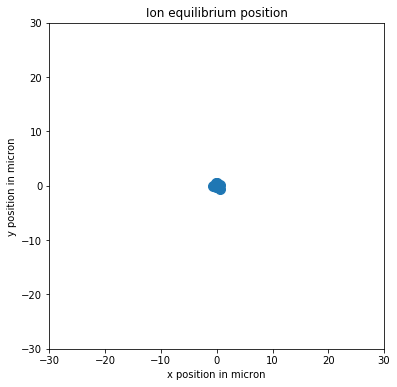

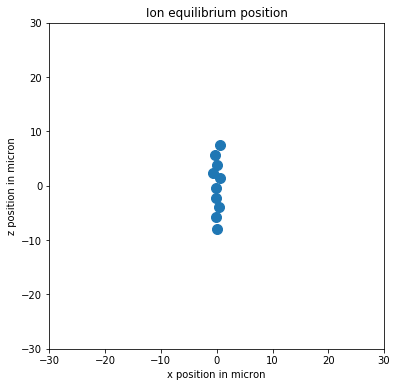

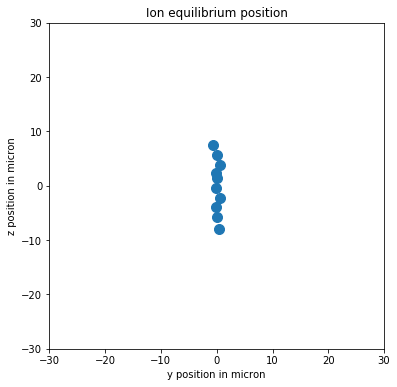

In [104]:
# Plot radial plane
xs = res.x[:N]
ys = res.x[N:2*N]
zs = res.x[2*N:3*N]

plt.figure(figsize=(6,6))
plt.scatter(xs*1e6, ys*1e6, marker='o',s = 100)
plt.title('Ion equilibrium position')
plt.xlabel('x position in micron')
plt.ylabel('y position in micron')
plt.ylim(-30,30)
plt.xlim(-30,30)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(xs*1e6, zs*1e6, marker='o',s = 100)
plt.title('Ion equilibrium position')
plt.xlabel('x position in micron')
plt.ylabel('z position in micron')
plt.ylim(-30,30)
plt.xlim(-30,30)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(ys*1e6, zs*1e6, marker='o',s = 100)
plt.title('Ion equilibrium position')
plt.xlabel('y position in micron')
plt.ylabel('z position in micron')
plt.ylim(-30,30)
plt.xlim(-30,30)
plt.show()

### Normal Modes
Ions motion can be used to send quantum information through the crystal. To do this, it's essential to know the normal modes of the ions. Let's compute them based on the ion positions

The energy potential for N identical ions in a linear Paul trap can be estimated as identical masses connected in a 3D harmonic potential. Each ion interacts through it's positive electric charge.

$$
L = \frac{1}{2}m\sum_{i=1}^{N}\left(\dot{x_i}^2 + \dot{y_i}^2 + \dot{z_i}^2\right) - \sum_{i=1}^{N}\left(\frac{1}{2}m \omega_x^2 x_i^2 + \frac{1}{2}m \omega_y^2 y_i^2 + \frac{1}{2}m \omega_z^2 z_i^2\right) - \frac{e^2}{4\pi \epsilon_0}\sum_{i\neq j}^{N}\frac{x_i x_j}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2}} + \frac{e^2}{4\pi \epsilon_0}\sum_{i\neq j}^{N}\frac{x_i^2}{\sqrt{(x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2}}
$$

equations of motion

$$
\sum_{i=1}^{N}\ddot{x_i} = -\sum_{i=1}^{N}\omega_x^2 x_i + \frac{e^2}{4 \pi \epsilon_0 m}\sum_{i<j}^{N}\frac{x_i - x_j}{\left((x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2\right)^{3/2}}
$$

$$
\sum_{i=1}^{N}\ddot{y_i} = -\sum_{i=1}^{N}\omega_y^2 y_i + \frac{e^2}{4 \pi \epsilon_0 m}\sum_{i<j}^{N}\frac{y_i - y_j}{\left((x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2\right)^{3/2}}
$$

$$
\sum_{i=1}^{N}\ddot{z_i} = -\sum_{i=1}^{N}\omega_z^2 z_i + \frac{e^2}{4 \pi \epsilon_0 m}\sum_{i<j}^{N}\frac{z_i - z_j}{\left((x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2\right)^{3/2}}
$$

$$
\sum_{i=1}^{N}\ddot{x_i} = \sum_{i=1}^{N}\omega_x^2 x_i - \frac{e^2}{4 \pi \epsilon_0 m}\left(\sum_{i=1}^{N}\sum_{j=i+1}^{N}\frac{x_i}{\left((x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2\right)^{3/2}} - \sum_{i=1}^{N}\sum_{j=i+1}^{N}\frac{x_j}{\left((x_i-x_j)^2 + (y_i-y_j)^2+ (z_i-z_j)^2\right)^{3/2}}\right)
$$

e.g. $i = 1$

$$
\ddot{x_1} = \omega_x^2 x_1 - \frac{e^2}{4 \pi \epsilon_0 m}\left(\sum_{j=2}^{N}\frac{x_1}{\left((x_1-x_j)^2 + (y_1-y_j)^2+ (z_1-z_j)^2\right)^{3/2}} - \sum_{j=2}^{N}\frac{x_j}{\left((x_1-x_j)^2 + (y_1-y_j)^2+ (z_1-z_j)^2\right)^{3/2}}\right)
$$

In [123]:
# Compute modes
def normal_modes(w):
    prefactor = -e**2/4/np.pi/epsilon_0/m

    # Add harmonic terms to matrix
    matrix = -w**2 * np.diag(np.ones(N))

    # Add interaction diagonal terms
    for i in range(N):
        interact_diag = 0
        for j in range(i+1,N):
            interact_diag += 1/((xs[i]-xs[j])**2+(ys[i]-ys[j])**2+(zs[i]-zs[j])**2)**(3/2)
        interact_diag *= prefactor
        matrix[i,i] += interact_diag

    # Add interaction cross terms 
    for i in range(N):
        for j in range(i+1,N):
            cross_term = -prefactor/((xs[i]-xs[j])**2+(ys[i]-ys[j])**2+(zs[i]-zs[j])**2)**(3/2)
            matrix[i,j] = cross_term
    return matrix

# Compute x mode
x_vals, x_vecs = np.linalg.eig(normal_modes(wx))
x_freqs = np.round(np.sqrt(np.abs(x_vals))/2/np.pi)
x_freqs, np.round(x_vecs, 4)

(array([5507066., 5027008., 5821036., 5379096., 4860890., 4996606.,
        5088901., 5064587., 4804074., 4800000.]),
 array([[ 1.    ,  0.0642, -0.0216,  0.2875,  0.3101,  0.0503, -0.0093,
         -0.056 ,  0.4627,  0.3162],
        [ 0.    ,  0.9979, -0.0022, -0.013 ,  0.734 , -0.0173,  0.0079,
          0.047 ,  0.461 ,  0.3162],
        [ 0.    ,  0.    ,  0.9998,  0.1858,  0.0036,  0.454 , -0.0527,
         -0.2793,  0.095 ,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.9395,  0.0146,  0.5613, -0.0864,
         -0.5473,  0.2612,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.6041, -0.0291, -0.0015,
          0.0111,  0.4675,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6893, -0.0941,
         -0.5864,  0.1157,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.9903,
          0.4301,  0.0061,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.2969,  0.0177,  0.3162],
        [ 

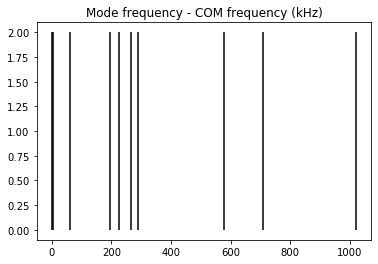

(array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
        0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777]),
 4800000.0,
 0.31622776601683794)

In [124]:
adjusted_freqs = (x_freqs - x_freqs[-1])/1000
plt.vlines(adjusted_freqs, [0]*N, [2]*N)
plt.title('Mode frequency - COM frequency (kHz)')
plt.show()

# Check COM mode is 1/np.sqrt(N)
x_vecs[:,9], np.sqrt(np.abs(x_vals[9]))/2/np.pi, 1/np.sqrt(N)

In [125]:
# Compute y modes
y_vals, y_vecs = np.linalg.eig(normal_modes(wy))
y_freqs = np.round(np.sqrt(np.abs(y_vals))/2/np.pi)
y_freqs, np.round(y_vecs, 4)

(array([5507066., 5027008., 5821036., 5379096., 4860890., 4996606.,
        5088901., 5064587., 4804074., 4800000.]),
 array([[ 1.    ,  0.0642, -0.0216,  0.2875,  0.3101,  0.0503, -0.0093,
         -0.056 ,  0.4627,  0.3162],
        [ 0.    ,  0.9979, -0.0022, -0.013 ,  0.734 , -0.0173,  0.0079,
          0.047 ,  0.461 ,  0.3162],
        [ 0.    ,  0.    ,  0.9998,  0.1858,  0.0036,  0.454 , -0.0527,
         -0.2793,  0.095 ,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.9395,  0.0146,  0.5613, -0.0864,
         -0.5473,  0.2612,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.6041, -0.0291, -0.0015,
          0.0111,  0.4675,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6893, -0.0941,
         -0.5864,  0.1157,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.9903,
          0.4301,  0.0061,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.2969,  0.0177,  0.3162],
        [ 

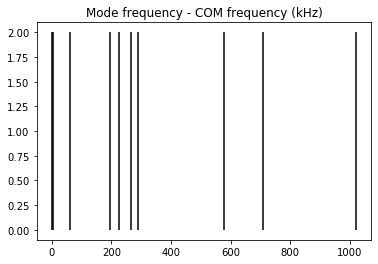

(array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
        0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777]),
 4800000.0,
 0.31622776601683794)

In [126]:
adjusted_freqs = (y_freqs - y_freqs[-1])/1000
plt.vlines(adjusted_freqs, [0]*N, [2]*N)
plt.title('Mode frequency - COM frequency (kHz)')
plt.show()

# Check COM mode is 1/np.sqrt(N)
y_vecs[:,9], np.sqrt(np.abs(y_vals[9]))/2/np.pi, 1/np.sqrt(N)

In [127]:
# Compute z modes

# THERE SHOULD NOT BE MODES LOWER THAN THE COM MODE (in the axial direction)

z_vals, z_vecs = np.linalg.eig(normal_modes(wz))
z_freqs = np.round(np.sqrt(np.abs(z_vals))/2/np.pi)
z_freqs, np.round(z_vecs, 4)

(array([2878850., 1797447., 3441579., 2625771., 1260258., 1710577.,
        1963902., 1900010., 1019376., 1000000.]),
 array([[ 1.    ,  0.0642, -0.0216,  0.2875,  0.3101,  0.0503, -0.0093,
         -0.056 ,  0.4627,  0.3162],
        [ 0.    ,  0.9979, -0.0022, -0.013 ,  0.734 , -0.0173,  0.0079,
          0.047 ,  0.461 ,  0.3162],
        [ 0.    ,  0.    ,  0.9998,  0.1858,  0.0036,  0.454 , -0.0527,
         -0.2793,  0.095 ,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.9395,  0.0146,  0.5613, -0.0864,
         -0.5473,  0.2612,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.6041, -0.0291, -0.0015,
          0.0111,  0.4675,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6893, -0.0941,
         -0.5864,  0.1157,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.9903,
          0.4301,  0.0061,  0.3162],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.2969,  0.0177,  0.3162],
        [ 

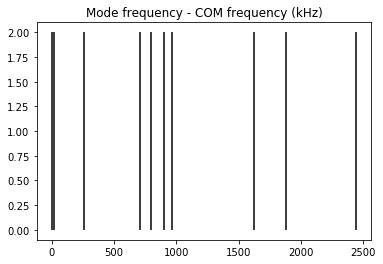

(array([0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777,
        0.31622777, 0.31622777, 0.31622777, 0.31622777, 0.31622777]),
 1000000.0,
 0.31622776601683794)

In [128]:
adjusted_freqs = (np.abs(z_freqs) - z_freqs[-1])/1000
plt.vlines(adjusted_freqs, [0]*N, [2]*N)
plt.title('Mode frequency - COM frequency (kHz)')
plt.show()

# Check COM mode is 1/np.sqrt(N)
z_vecs[:,9], np.sqrt(np.abs(z_vals[9]))/2/np.pi, 1/np.sqrt(N)

### Ion-ion interactions
The effective interaction term is along kth axis is

$$
J_{ij} = \Omega^2 \frac{\hbar \Delta k^2}{2 m}\sum_{m=1}^N\frac{b_{im} b_{jm}}{\mu^2-(\omega_m^k)^2}
$$

where $b_{im}$ is the normal mode eigenvector component of the ith ion in mode m.

In [8]:
hbar = 1.054571817e-34
Omega = 2*np.pi * 1.5e6
dk = np.sqrt(2) / 355e-9
mu = 2*np.pi * 350e3

def J_ij(i, j, i_eig_vec, j_eig_vec, mu, ws, Omega=Omega, m=m, hbar=hbar, dk=dk):
    prefactor = Omega**2 * hbar*dk**2/2/m
    num_modes = i_eig_vec.shape[1]
    J_ij = 0
    for m in range(num_modes):
        J_ij += (i_eig_vec[i,m] * j_eig_vec[j,m])/(mu**2 - ws[m]**2)
    return prefactor * i_eig_vec[i]
